# Predictive Modeling for NASDAQ Closing Auctions

## Introduction
This project is a culmination of our efforts to understand and model the NASDAQ closing auction, where the final prices of stocks are determined. Our aim is to unravel the intricacies behind the short-term price movements during the auction's critical 10-minute window.

## Project Objective
- **Goal**: Predict the forward price movements during the NASDAQ's Closing Cross Auction.

## Approach Overview
Our systematic approach includes:

  ### Data Analysis
  - Conducting a thorough examination of the dataset to glean insights into the auction process and key influencing factors.

  ### Data Preparation
  - Cleaning and preprocessing the dataset to ensure data integrity and readiness for modeling.

  ### Feature Engineering
  - Developing new features from financial indicators and auction dynamics to enhance our predictive model.

  ### Technical Indicators
  - Integrating established technical indicators such as EMA, VMA, and Volatility.

  ### Predictive Modeling
  - Employing advanced machine learning techniques to build and train our predictive model.

  ### Model Evaluation
  - Using rigorous metrics to evaluate the model's performance and identify opportunities for refinement.

By following this structured approach, we aim to build a model that not only predicts with accuracy but also offers valuable insights into the closing auction mechanics.



## Initial EDA

### Initial Data Loading
We begin by importing necessary libraries and loading the dataset. A preliminary look at the data helps us understand the basic features available for our analysis.


In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.impute import KNNImputer
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tensorflow as tf
import random as python_random
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
from xgboost import XGBRegressor, plot_importance
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


### Data Summary
A quantitative overview provides insights into the unique identifiers within our dataset such as `stock_id`, `date_id`, and `time_id`. We also examine the distribution of key numerical features.


In [ ]:
# Number of rows

row_num = df.shape[0]
print("Number of rows:", row_num)

Number of rows: 5237980


In [ ]:
# Quantitative analysis

unique_seconds_in_bucket = df['seconds_in_bucket'].unique()
unique_stock_ids = df['date_id'].unique()
unique_time_ids = df['time_id'].unique()
unique_stock_ids = df['stock_id'].unique()

print("Unique Seconds in Bucket:", unique_seconds_in_bucket)
print("Unique Date IDs:", unique_stock_ids)
print("Unique Time IDs", unique_time_ids)
print("Number of stocks", len(unique_stock_ids))

Unique Seconds in Bucket: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540]
Unique Date IDs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72
  73  74  75  76  77  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 151 152 154 155 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 1

From our analysis of time IDs, we can determine that we have been given the movement of 200 stocks over 10 minutes for 480 days.

In [ ]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


All of the data that we will be using to train the model is already in integer or float form except for the row_id, which is unnecessary to make predictions.

In [ ]:
df = df.drop(columns=['row_id'])
df.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
dtype: object

In order to save CPU memory, we convert our floats from float64 to float32.

In [ ]:
# List of columns to convert to float32
columns_to_convert = ['reference_price', 'matched_size', 'far_price', 'near_price',
                      'bid_price', 'bid_size', 'ask_price', 'ask_size',
                      'wap', 'target', 'imbalance_size']

# Convert the columns to float32
df[columns_to_convert] = df[columns_to_convert].astype('float32')
df.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float32
imbalance_buy_sell_flag      int64
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int64
dtype: object

### Cleaning and Encoding

Now that we have a more clear idea of how our data is being presented, we can add features and make changes to `df` that will make our data more presentable to a model.


Lets begin by addressing our nulls:

In [ ]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
dtype: int64

Analyzing the nulls in the dataset, we determine that the far price and near price are only released after 3:55.

We can also show that the movement over time for each stock changes dramatically after the 3:55 marks. We can conclude that at the release of the near and far prices the matched size and imbalance size change drastically.

When the market stops accepting Market on Close Orders at 3:55, it seems like trading strategy changes to matching as much as possible and maximize the amount of crosses at the end of the auction.

The strategy change gives use reason to logically seperate the prediction process for stocks before and after the 3:55 mark.


To seperate the logic for stocks before 3:55 and stocks after, we add a seperate 'boolean' (0 or 1) class called is_355.

In [ ]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715294e+06,-1.189619e-02,9.999961e-01,4.510024e+07,1.001713e+00,9.996603e-01,9.997261e-01,5.181356e+04,1.000264e+00,5.357570e+04,9.999929e-01,-4.756123e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279576e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


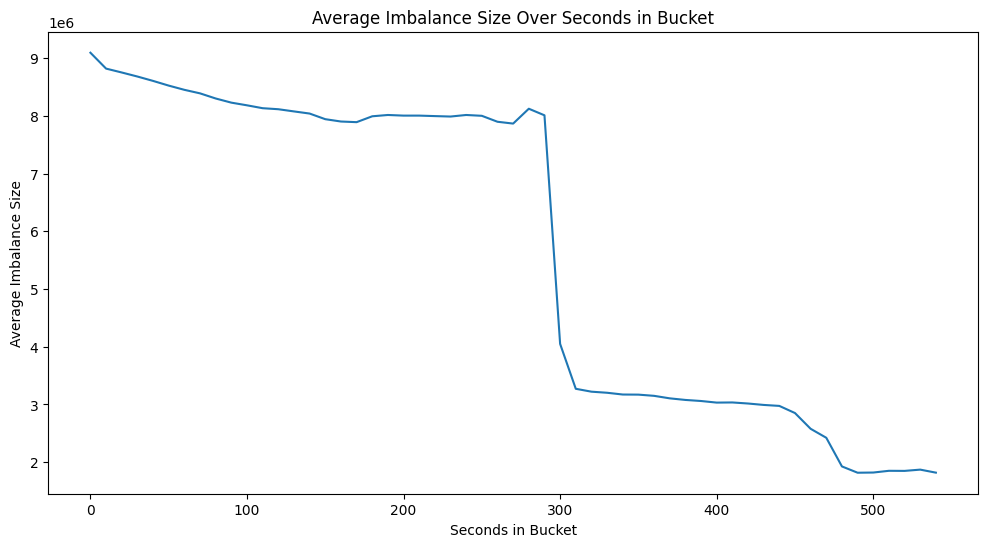

In [ ]:
bucket_grouped = df.groupby('seconds_in_bucket').mean()
plt.figure(figsize=(12, 6))
plt.plot(bucket_grouped['imbalance_size'])
plt.title('Average Imbalance Size Over Seconds in Bucket')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Average Imbalance Size')
plt.show()

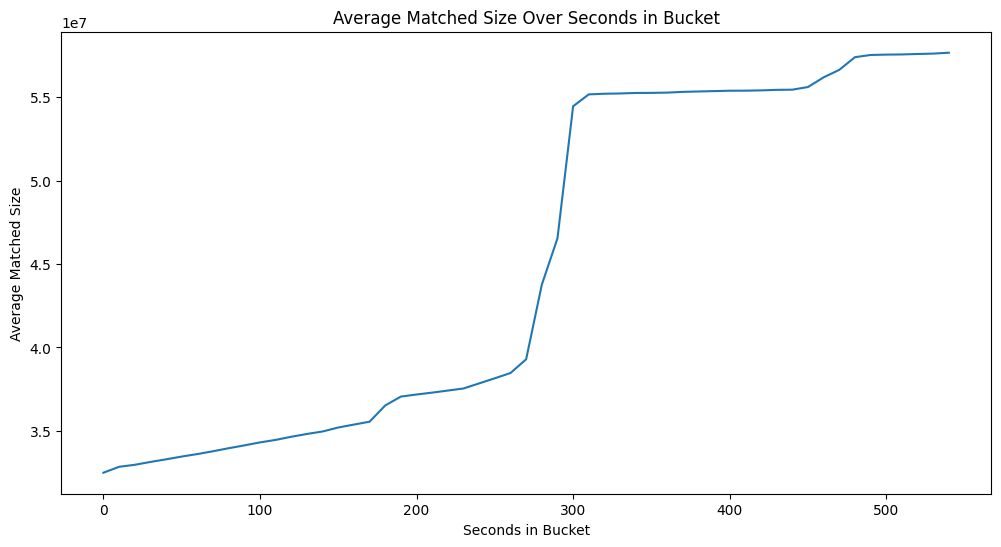

In [ ]:
bucket_grouped = df.groupby('seconds_in_bucket').mean()
plt.figure(figsize=(12, 6))
plt.plot(bucket_grouped['matched_size'])
plt.title('Average Matched Size Over Seconds in Bucket')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Average Matched Size')
plt.show()

Unfortunatly, we still have some nulls in our dataframe. In order to correct further lets use an imputer on each grouping of stocks. We need to ensure that the imputer acts on each stock individually and does not consider data from other stocks when calculating an intermediate value.

$$ $$
We will use the KNN Imputer because while the computation may be more time consuming there is not an unreasonable amount of data to replace

In [ ]:
df['is_355'] = df['seconds_in_bucket'].apply(lambda x: 1 if x >= 300 else 0)
df.loc[df['is_355'] == 0, ['near_price', 'far_price']] = 0


In [ ]:
def knn_interpolate_group(group):
    imputer = KNNImputer(n_neighbors=2)
    group['far_price'] = imputer.fit_transform(group[['far_price']])

    return group

df = df.groupby('stock_id', group_keys=False).apply(knn_interpolate_group)

In [ ]:
#df.describe()

Observing the rest of the null values, using an imputer won't be that efficient because what is left to remove is not a significant amount of data nor a significant timeframe. Therefore we will drop these columns.

In [ ]:
df[df.isnull().any(axis=1)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,is_355
369508,131,35,0,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,1925,0
369700,131,35,10,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,1926,0
369892,131,35,20,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,1927,0
370084,131,35,30,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,1928,0
370276,131,35,40,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,1929,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774999,19,438,500,NaN,-1,NaN,NaN,0.447739,NaN,NaN,115491.179688,NaN,1990.099976,NaN,3.319979,24140,1
4775199,19,438,510,NaN,-1,NaN,NaN,0.447739,NaN,NaN,189040.500000,NaN,26283.839844,NaN,-5.049706,24141,1
4775399,19,438,520,NaN,-1,NaN,NaN,0.447739,NaN,NaN,1392.930054,NaN,43799.800781,NaN,-0.110269,24142,1
4775599,19,438,530,NaN,-1,NaN,NaN,0.447739,NaN,NaN,13531.320312,NaN,26881.199219,NaN,-1.689792,24143,1


In [ ]:
df = df.dropna()
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,is_355
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,0.0,0.0,0.999812,60651.500000,1.000026,8493.030273,1.0,-3.029704,0,0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.040039,1.000660,20605.089844,1.0,-5.519986,0,0
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,0.0,0.0,0.999403,37956.000000,1.000298,18995.000000,1.0,-8.389950,0,0
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,0.0,0.0,0.999999,2324.899902,1.000214,479032.406250,1.0,-4.010201,0,0
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,0.0,0.0,0.999394,16485.539062,1.000016,434.100006,1.0,-7.349849,0,0


##Feature Engineering

In our effort to refine the predictive model for NASDAQ closing auction price movements, we have engineered several new features that encapsulate different market dynamics:

### Total Volume
Found by aggregating the size of the ask (sell orders) and bid (buy orders). This figure represents the total quantity of shares offered for sale and purchase, providing insight into the market's liquidity at any given moment.

### Imbalance Ratio
 Derived from the disparity between the `imbalance_size` and `matched_size`. It provides a normalized view of the imbalance's relative magnitude compared to the volume of matched trades.

In [ ]:
# total volume --> summing the ask size and bid size
df["volume"] = df["ask_size"] + df["bid_size"]

# relative imbalance between matched and total size
df["imbalance_ratio"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])

# difference between ask price and bid price
df["price_spread"] = df["ask_price"] - df["bid_price"]

# product of imbalance size and bid-ask spread
df["price_pressure"] = df["imbalance_size"] * (df["price_spread"])

<ipython-input-17-767c12eb9647>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["volume"] = df["ask_size"] + df["bid_size"]
<ipython-input-17-767c12eb9647>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["imbalance_ratio"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])
<ipython-input-17-767c12eb9647>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Exponential Moving Average (EMA) Feature Engineering

The Exponential Moving Average (EMA) is a crucial feature in time series analysis, particularly in financial markets. It serves as a technical indicator that can help predict future price movements by smoothing out price data over a specified period. Here's why we incorporate EMA into our feature set:

#### Significance of EMA:
- **Trend Identification**: EMA helps identify the prevailing trend in stock prices. A rising EMA indicates an uptrend, while a falling EMA suggests a downtrend.
- **Responsiveness**: Unlike the Simple Moving Average (SMA), EMA gives more weight to recent prices, making it more responsive to recent price changes. This property is particularly useful in a fast-paced auction environment where recent price movements can be indicative of imminent trends.
- **Support and Resistance Levels**: EMAs can act as support or resistance levels in price charts. Stocks may experience a rebound when approaching the EMA line, or the EMA can act as a ceiling that the price struggles to break through.

#### Engineering EMA:
To construct the EMA feature for our dataset:
1. **Granularity**: We compute the EMA for each stock (`stock_id`) within each trading day (`date_id`) to maintain granular insights and avoid any signal dilution that would arise from aggregating across different days or stocks.
2. **Span Selection**: The span value chosen for calculating EMA represents the number of periods over which the average is computed. In our case, with a period defined as 10 seconds, we use various span values to capture short-term and long-term trends.
3. **Grouped Calculation**: We ensure that the EMA for a given stock on a given day is influenced only by the price movements (`wap`) within that specific day. This grouping maintains the integrity of the temporal sequence and avoids lookahead bias.

### Usage in Model:
- We use EMA as a feature in our model to provide a smoothed representation of price movements.
- By including EMA, the model can better understand the momentum and trend direction, which are essential in predicting the short-term price movements during the auction period.


In [ ]:
# Exponential Moving Average for Wap
def calculate_ema(dataset, time_column='date_id', stock_column='stock_id', span_values=[13, 26, 54], columns_to_average=['wap', 'reference_price', 'volume']):

     if columns_to_average is None:
         columns_to_average = dataset.select_dtypes(include='number').columns.tolist()

     new_columns = []
     for span_value in span_values:
         for column in columns_to_average:
             ema_column_name = f'{column}_EMA_{span_value}'
             # new_columns.append(dataset.groupby(time_column)[column].transform(lambda x: x.ewm(span=span_value, min_periods=1).mean()))
             dataset[ema_column_name] = dataset.groupby([stock_column, time_column])[column] \
                                               .transform(lambda x: x.ewm(span=span_value, min_periods=1).mean())
     return dataset


df = calculate_ema(df, time_column='date_id')
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,price_pressure,wap_EMA_13,reference_price_EMA_13,volume_EMA_13,wap_EMA_26,reference_price_EMA_26,volume_EMA_26,wap_EMA_54,reference_price_EMA_54,volume_EMA_54
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,0.0,0.0,0.999812,...,680.587524,1.0,0.999812,69144.531250,1.0,0.999812,69144.531250,1.0,0.999812,69144.531250
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,0.0,0.0,0.999896,...,127.277512,1.0,0.999896,23838.128906,1.0,0.999896,23838.128906,1.0,0.999896,23838.128906
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,0.0,0.0,0.999403,...,271.084564,1.0,0.999561,56951.000000,1.0,0.999561,56951.000000,1.0,0.999561,56951.000000
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,0.0,0.0,0.999999,...,2562.229492,1.0,1.000171,481357.312500,1.0,1.000171,481357.312500,1.0,1.000171,481357.312500
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,0.0,0.0,0.999394,...,278.364655,1.0,0.999532,16919.638672,1.0,0.999532,16919.638672,1.0,0.999532,16919.638672


<Figure size 1500x500 with 0 Axes>

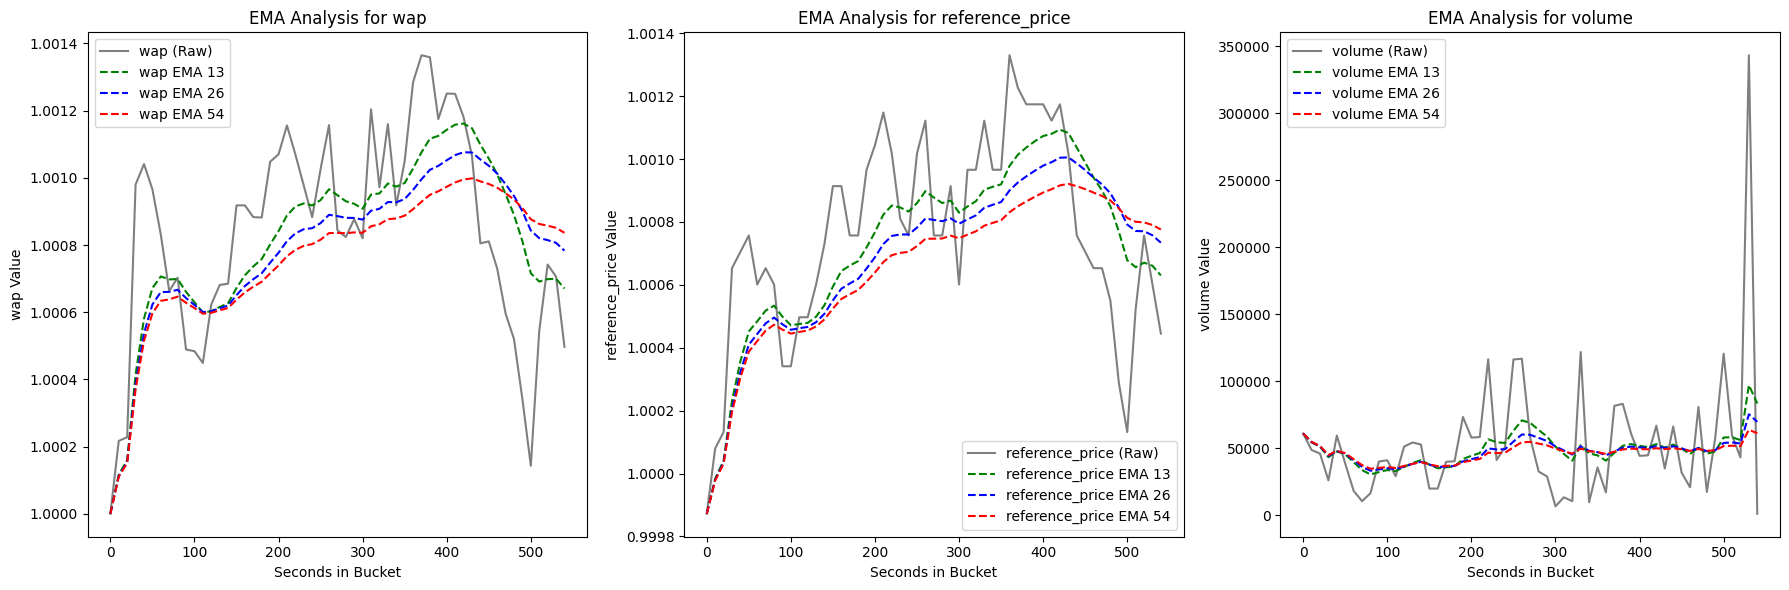

In [ ]:
stock_id_to_plot = 10
date_id_to_plot = 10

# Filter the DataFrame for the specified stock ID and date ID
stock_data = df[(df['stock_id'] == stock_id_to_plot) & (df['date_id'] == date_id_to_plot)]

# Ensure the data is sorted by 'seconds_in_bucket'
stock_data_sorted = stock_data.sort_values(by='seconds_in_bucket')

# Plot settings
plt.figure(figsize=(15, 5))

columns_to_plot = ['wap','reference_price', 'volume']
plt.figure(figsize=(18, 6))


for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns, ith subplot
    plt.plot(stock_data_sorted['seconds_in_bucket'], stock_data_sorted[column], label=f'{column} (Raw)', color='black', alpha=0.5)
    plt.plot(stock_data_sorted['seconds_in_bucket'], stock_data_sorted[f'{column}_EMA_13'], label=f'{column} EMA 13', linestyle='--', color='green')
    plt.plot(stock_data_sorted['seconds_in_bucket'], stock_data_sorted[f'{column}_EMA_26'], label=f'{column} EMA 26', linestyle='--', color='blue')
    plt.plot(stock_data_sorted['seconds_in_bucket'], stock_data_sorted[f'{column}_EMA_54'], label=f'{column} EMA 54', linestyle='--', color='red')

    plt.xlabel('Seconds in Bucket')
    plt.ylabel(f'{column} Value')
    plt.title(f'EMA Analysis for {column}')
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

These particular columns that we calculated EMA on were found to be important values when we run all features on a KGBoost model and graph feature importance (done below). The span values were chosen based on the total number of periods for each `date_id`, which is 54. We see that larger windows produce a smoother EMA, whereas shorter span windows are much more seneitive to short-term fluctuation. The KGBoost will similarly inform us on which span winows will provide us with the most important features derived from EMA for our model.

### Rolling Standard Deviation (Volatility)

Rolling Standard Deviation is a commonly used technical indicator in financial analysis, particularly for assessing price volatility in financial markets. It quantifies the degree of price variability or dispersion in a time series of data points. In the context of trading and investment, volatility is an essential factor as it can provide insights into the potential risk and uncertainty associated with asset prices.


### Rolling Standard Deviation for WAP

In our model, we use the rolling standard deviation of the Weighted Average Price (WAP) to assess the volatility of each stock. Here's how it's calculated:

- We group the data by 'stock_id' using `df.groupby('stock_id')`.

- For each stock, we calculate the rolling standard deviation of the WAP using the `transform` function. The rolling window is set to 60 time periods (which may represent minutes, seconds, etc., depending on the dataset's time granularity).

- The rolling standard deviation provides a measure of how much the WAP values for a particular stock fluctuate over the specified time window. A higher standard deviation indicates greater price variability, while a lower standard deviation suggests more stable prices.



In [ ]:
df['rolling_std_wap'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=54).std())

####Rolling Standard Deviation for Matched Size

In our model, we use the rolling standard deviation of the `matched_size` to assess the volatility of the auction book. The `matched_size` column contains the number of shares at any point in time that can be matched from the bid/ask columns (they represent the number of shares where there is a buyer and seller who agree on a middle-ground `reference_price`). Here's how it's calculated:

We group the data by 'stock_id' using df.groupby('stock_id').

For each stock, we calculate the rolling standard deviation of the `matched_size` using the transform function. The rolling window is set to 54 time periods (which may represent minutes, seconds, etc., depending on the dataset's time granularity).

The rolling standard deviation provides a measure of how much the `matched_size` values for a particular stock fluctuate over the specified time window. A higher standard deviation indicates greater price variability, while a lower standard deviation suggests more stable prices.

In [ ]:
df['rolling_std_matched_size'] = df.groupby('stock_id')['matched_size'].transform(lambda x: x.rolling(window=54).std())

#### Rolling Standard Deviation for Reference Price

In our model, we use the rolling standard deviation of the `reference_price` to gauge the price stability of each stock. Here's how it's calculated:

We group the data by `stock_id` using df.groupby(`stock_id`).

For each stock, we compute the rolling standard deviation of the `reference_price` using the transform function. The rolling window is set to 54 time periods representing the 54 periods present in each day (since there are 54, 10-second intervals in each `date_id`).

The rolling standard deviation serves as a metric to assess how the `reference_price` values for a particular stock change within the specified time window. A higher standard deviation suggests greater price variability, indicating potential price fluctuations, while a lower standard deviation indicates more stable prices.

In [ ]:
df['rolling_std_reference_price'] = df.groupby('stock_id')['reference_price'].transform(lambda x: x.rolling(window=54).std())

### Volume-Weighted Average

The VWAP is a trading benchmark that gives the average price a stock has traded at throughout a day, based on both volume and price. It is important because it provides traders with insight into both the trend and value of a security.



##### Calculation of VWAP with Reference Price:
- This particular implementation of VWAP multiplies the `wap` (Weighted Average Price) by the `reference_price`, summing this product over time and then dividing by the cumulative sum of `volume`.
- This variation emphasizes the `reference_price`, integrating it into the VWAP calculation to reflect the average price at which the stock was intended to trade versus its actual trading price.

In [ ]:
#Volume Reference Price
def calculate_vwap(df):
    df['vwap_reference_price'] = (df['wap'] * df['reference_price']).cumsum() / df['volume'].cumsum()
    return df
df = calculate_vwap(df)
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap_EMA_26,reference_price_EMA_26,volume_EMA_26,wap_EMA_54,reference_price_EMA_54,volume_EMA_54,rolling_std_wap,rolling_std_matched_size,rolling_std_reference_price,vwap_reference_price
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,0.0,0.0,0.999812,...,1.0,0.999812,69144.531250,1.0,0.999812,69144.531250,NaN,NaN,NaN,0.000014
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,0.0,0.0,0.999896,...,1.0,0.999896,23838.128906,1.0,0.999896,23838.128906,NaN,NaN,NaN,0.000022
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,0.0,0.0,0.999403,...,1.0,0.999561,56951.000000,1.0,0.999561,56951.000000,NaN,NaN,NaN,0.000020
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,0.0,0.0,0.999999,...,1.0,1.000171,481357.312500,1.0,1.000171,481357.312500,NaN,NaN,NaN,0.000006
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,0.0,0.0,0.999394,...,1.0,0.999532,16919.638672,1.0,0.999532,16919.638672,NaN,NaN,NaN,0.000008


##### Calculation of VWAP with Matched Size:

- In this computation, the `wap` is multiplied by the `matched_size`, which represents the volume of stocks that have been matched in trades.
- It then takes the cumulative sum of this product and divides by the cumulative sum of `volume`, providing a VWAP that is weighted towards the volume of stocks that were actually traded.

In [ ]:
#Volume matched_size
def calculate_vwap(df):
    df['vwap_matched_size'] = (df['wap'] * df['matched_size']).cumsum() / df['volume'].cumsum()
    return df
df = calculate_vwap(df)
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,reference_price_EMA_26,volume_EMA_26,wap_EMA_54,reference_price_EMA_54,volume_EMA_54,rolling_std_wap,rolling_std_matched_size,rolling_std_reference_price,vwap_reference_price,vwap_matched_size
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,0.0,0.0,0.999812,...,0.999812,69144.531250,1.0,0.999812,69144.531250,NaN,NaN,NaN,0.000014,193.511719
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,0.0,0.0,0.999896,...,0.999896,23838.128906,1.0,0.999896,23838.128906,NaN,NaN,NaN,0.000022,161.562286
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,0.0,0.0,0.999403,...,0.999561,56951.000000,1.0,0.999561,56951.000000,NaN,NaN,NaN,0.000020,112.328751
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,0.0,0.0,0.999999,...,1.000171,481357.312500,1.0,1.000171,481357.312500,NaN,NaN,NaN,0.000006,55.808823
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,0.0,0.0,0.999394,...,0.999532,16919.638672,1.0,0.999532,16919.638672,NaN,NaN,NaN,0.000008,81.905823


### Feature Importance using XGBoost
Now, we're using an XGBoost model in order to graph feature importance of our dataframe. We'll use this information to inform our feature selected for the LSTM model.

In [ ]:
# X = df.drop(columns=['target'])
# y = df['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = XGBRegressor()
# model.fit(X_train, y_train)


# plt.figure(figsize=(20, 12))

# plot_importance(model)
# plt.show()


### Checking Variable Correlation

Now we are checking all of the variables within the dataset using a correlation matrix, and we are going to filter out the highly correlated variables.

In [ ]:
# correlation_matrix = df.corr()
# plt.figure(figsize=(16, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# plt.title('Correlation Matrix')
# plt.show()


Based on the Feature Importance graph generated based on our KGBoost model and the correlation matrix, we're informed on which features it would be beneficial to remove.

We remove columns that are:
1. Notably unimportant according to our Feature Importance graph.
2. Highly correlated, according to our Corerlation Matrix.


In [ ]:
df = df.drop(['volume_EMA_13', 'volume_EMA_26', 'volume_EMA_54',  'reference_price_EMA_13',
         'reference_price_EMA_26', 'wap_EMA_26', 'wap_EMA_54',
         'vwap_reference_price', 'vwap_matched_size', 'near_price'], axis=1)

Now, let's see our correlation matrix again...

In [ ]:
# correlation_matrix = df.corr()
# plt.figure(figsize=(16, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# plt.title('Correlation Matrix')
# plt.show()

# Making and Training the Model

For the model, we trained a neural network not covered in class called an LSTM (long short term memory).

Initially we opted to use a FFN, but quickly realised that an FFN would not have any way to recognise time based relationships. Therefore, we researched models that we could use and settled on an LSTM



Base model hyperparameters

In [ ]:
SEED = 42
N_LAGS = 55
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 10
PATIENCE = 25
DROPOUT = 0.5
LEARNING_RATE = 1e-4
SPLIT_DAY = 390
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55
RUN_TRAINING = True
RUN_FOR_SUBMISSION = True

Formats the data to be able to be inserted into the LSTM

In [ ]:
def windowed_dataset(dataset, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
      dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset


def build_features(df):

    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()

    df_pivoted = df_full.pivot_table(
                values='target',
                index=['date_id', 'seconds_in_bucket'],
                columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

Builds the model

In [ ]:
build_features(df)

def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

Trains the base model

In [ ]:
if RUN_TRAINING:

  split = df['date_id'] > SPLIT_DAY
  df_train = df[~split]
  df_valid = df[split]

  df_train_features = build_features(df_train)
  df_valid_features = build_features(df_valid)

  scaler = StandardScaler()
  train_features = scaler.fit_transform(df_train_features)
  valid_features = scaler.transform(df_valid_features)

  train_dataset = windowed_dataset(train_features)
  valid_dataset = windowed_dataset(valid_features, shuffle=False)

  model = build_model()

  early_stopping = EarlyStopping(monitor='val_loss',
                    mode='min',
                    patience=PATIENCE,
                    restore_best_weights=True,
                    verbose=True)

  history = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=[early_stopping],
                      verbose=True)

  ## Evaluate ##
  y_pred = model.predict(valid_dataset)

  y_pred = scaler.inverse_transform(y_pred)
  y_true = df_valid_features[N_LAGS:]

  mae = mean_absolute_error(y_true, y_pred)
  print(f"MAE score: {mae}")

Epoch 1/10
671/671 [==============================] - 24s 15ms/step - loss: 0.7362 - val_loss: 0.6846
Epoch 2/10
671/671 [==============================] - 13s 8ms/step - loss: 0.7272 - val_loss: 0.6789
Epoch 3/10
671/671 [==============================] - 10s 9ms/step - loss: 0.7198 - val_loss: 0.6743
Epoch 4/10
671/671 [==============================] - 9s 8ms/step - loss: 0.7143 - val_loss: 0.6711
Epoch 5/10
671/671 [==============================] - 11s 7ms/step - loss: 0.7102 - val_loss: 0.6689
Epoch 6/10
671/671 [==============================] - 9s 10ms/step - loss: 0.7072 - val_loss: 0.6670
Epoch 7/10
671/671 [==============================] - 9s 7ms/step - loss: 0.7050 - val_loss: 0.6654
Epoch 8/10
671/671 [==============================] - 10s 9ms/step - loss: 0.7031 - val_loss: 0.6639
Epoch 9/10
671/671 [==============================] - 8s 8ms/step - loss: 0.7015 - val_loss: 0.6626
Epoch 10/10
153/153 [==============================] - 1s 7ms/step
MAE score: 5.8707027435302

Plots the base model

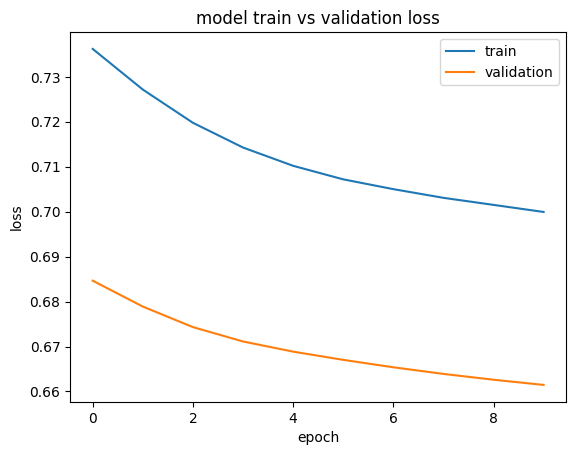

In [ ]:
## Plots ##
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Retrains the model using hyperparameter tuning and returns the optimal lowest MAE.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import itertools

SEED = 42
N_LAGS = 55
BUFFER_SIZE = 100000
SPLIT_DAY = 390
N_STOCKS = 200
N_SECONDS = 55
RUN_TRAINING = True
PATIENCE = 25
EPOCHS = 10

# Hyperparameters
param_grid = {
    'N_LAGS': [55, 60, 65],
    'BATCH_SIZE': [32, 64],
    'DROPOUT': [0.3, 0.5, 0.7],
    'LEARNING_RATE': [1e-4, 1e-3],
    'LSTM_UNITS': [25, 50]
}

best_mae = float('inf')
best_hyperparameters = None

def windowed_dataset(dataset, shuffle=True, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def build_features(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()

    df_pivoted = df_full.pivot_table(
        values='target',
        index=['date_id', 'seconds_in_bucket'],
        columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

if RUN_TRAINING:
    split = df['date_id'] > SPLIT_DAY
    df_train = df[~split]
    df_valid = df[split]

    df_train_features = build_features(df_train)
    df_valid_features = build_features(df_valid)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train_features)
    valid_features = scaler.transform(df_valid_features)

    train_dataset = windowed_dataset(train_features)
    valid_dataset = windowed_dataset(valid_features, shuffle=False)

    for params in itertools.product(*param_grid.values()):
        hyperparameters = dict(zip(param_grid.keys(), params))

        def build_model(dropout=hyperparameters['DROPOUT'], lstm_units=hyperparameters['LSTM_UNITS']):
            model = Sequential()
            model.add(Input(shape=(hyperparameters['N_LAGS'], N_STOCKS)))
            model.add(Dropout(dropout))
            model.add(LSTM(lstm_units, return_sequences=False))
            model.add(Dropout(dropout))
            model.add(Dense(N_STOCKS))
            model.compile(loss='mae',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters['LEARNING_RATE']))
            return model

        model = build_model()

        early_stopping = EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=PATIENCE,
                                       restore_best_weights=True,
                                       verbose=True)

        history = model.fit(train_dataset,
                            validation_data=valid_dataset,
                            epochs=EPOCHS,
                            batch_size=hyperparameters['BATCH_SIZE'],
                            callbacks=[early_stopping],
                            verbose=True)

        y_pred = model.predict(valid_dataset)

        y_pred = scaler.inverse_transform(y_pred)
        y_true = df_valid_features[N_LAGS:]

        mae = mean_absolute_error(y_true, y_pred)
        print(f"MAE score for hyperparameters {hyperparameters}: {mae}")

        if mae < best_mae:
            best_mae = mae
            best_hyperparameters = hyperparameters

    print(f"Best hyperparameters: {best_hyperparameters}, Best MAE: {best_mae}")

